# Projet Water IA - Analyse et Modélisation

Ce notebook présente l'analyse complète des données de consommation d'eau, visant à comprendre la baisse des revenus FDE et à modéliser le comportement des clients.

In [1]:
# Manipulation de données
import pandas as pd
import numpy as np
import os

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Prétraitement
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

# Modèles de Régression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression

# Modèles de Classification
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier

# Clustering
from sklearn.cluster import KMeans

# Métriques d'évaluation
from sklearn.metrics import (
    mean_squared_error, r2_score, mean_absolute_error,
    confusion_matrix, accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, roc_auc_score
)

# Gestion des classes déséquilibrées
from imblearn.over_sampling import SMOTE

# Ignorer les avertissements pour une meilleure lisibilité
import warnings
warnings.filterwarnings('ignore')

# Configuration de l'affichage
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

print("Bibliothèques importées avec succès.")

Bibliothèques importées avec succès.


## 1. Chargement et Préparation des Données

Nous commençons par charger l'ensemble des fichiers de données. Chaque fichier `.txt` correspond à une Direction Régionale (DR). Conformément au plan, nous allons :
1.  Identifier tous les fichiers de données dans le répertoire `datasets/`.
2.  Charger chaque fichier dans un DataFrame `pandas`, en supposant un format CSV.
3.  Concaténer tous les DataFrames en un seul pour l'analyse globale.

Cette approche permet de travailler sur l'intégralité des 23 millions d'observations.

In [2]:
# Définir le chemin vers le dossier des données
data_path = 'datasets/'

# Lister les fichiers à charger (en s'assurant que le dossier existe)
if not os.path.exists(data_path):
    print(f"Le dossier '{data_path}' n'existe pas. Veuillez le créer et y placer les fichiers de données.")
else:
    file_names = [f for f in os.listdir(data_path) if f.endswith('.txt')]

    # Créer une liste pour stocker les DataFrames individuels
    list_df = []

    # Charger chaque fichier et l'ajouter à la liste
    for file in file_names:
        try:
            # On suppose que le séparateur est une virgule, comme suggéré par l'en-tête fourni.
            # On utilise `low_memory=False` pour optimiser le chargement de gros fichiers avec des types mixtes.
            df_temp = pd.read_csv(
                os.path.join(data_path, file),
                sep=',',
                low_memory=False
            )
            list_df.append(df_temp)
            print(f"Fichier '{file}' chargé avec succès ({len(df_temp)} lignes).")
        except Exception as e:
            print(f"Erreur lors du chargement du fichier {file}: {e}")

    # Concaténer tous les DataFrames s'ils ont été chargés
    if list_df:
        df = pd.concat(list_df, ignore_index=True)

        # Afficher les informations sur le DataFrame combiné
        print("\
Chargement des données terminé.")
        print(f"Nombre total de lignes chargées : {len(df)}")
        print(f"Dimensions du DataFrame : {df.shape}")
        print("\
Aperçu des données :")
        display(df.head())
        print("\
Informations sur les colonnes et types de données :")
        df.info()
    else:
        print("Aucun fichier n'a été chargé.")

Erreur lors du chargement du fichier DR16..txt: [Errno 13] Permission denied: 'datasets/DR16..txt'
Fichier 'DR16.txt' chargé avec succès (1323943 lignes).
Erreur lors du chargement du fichier DR2..txt: [Errno 13] Permission denied: 'datasets/DR2..txt'
Fichier 'DR2.txt' chargé avec succès (1526258 lignes).
Erreur lors du chargement du fichier DR21..txt: [Errno 13] Permission denied: 'datasets/DR21..txt'
Fichier 'DR21.txt' chargé avec succès (2346796 lignes).
Fichier 'DR6.txt' chargé avec succès (1265439 lignes).
Fichier 'DR7.txt' chargé avec succès (1407444 lignes).
Fichier 'DR9.txt' chargé avec succès (634767 lignes).
Chargement des données terminé.
Nombre total de lignes chargées : 8504647
Dimensions du DataFrame : (8504647, 35)
Aperçu des données :


,DR,CEN,POLICE,O,P,ENR,MM,AAAA,DATE-FACT,DIAM,CUBCONS,CUBFAC,FORFAIT,SOCIAL,DOMEST,NORMAL,INDUST,ADMINI,MONT-SOD,MONT-TVA,MONT-FDE,MONT-FNE,MONT-ASS-TTC,MONT-FRAIS-CPT,MONT-TTC,DATE-ABON,DATE-RESIL,TOURNEE,DATE-REGLT,AAENC,MMENC,RESILIE,CATEGORIE,NOUVEAU,DATE-REGLT-ENC
0,16,2,17838,1,3,EN,8,2019,2019-09-20 00:00:00.000,1,0.0,9,9,0,0,0,0,0,2052,0,63,0,0,0.0,2019-04-01 00:00:00.000,NaN,NaN,46.0,2019-10-21 00:00:00.000,2019.0,10,0.0,PRIVE,1.0,68
1,16,2,17838,1,3,EN,11,2019,2019-12-20 00:00:00.000,1,0.0,9,9,0,0,0,0,0,2052,0,63,0,0,0.0,2019-04-01 00:00:00.000,NaN,NaN,46.0,NaN,NaN,NaN,0.0,PRIVE,1.0,71
2,16,2,17839,4,3,EN,3,2019,2019-04-08 00:00:00.000,1,84.0,84,9,9,66,0,0,0,19152,2706,5228,1386,0,0.0,2011-09-14 00:00:00.000,NaN,NaN,1.0,2019-06-04 00:00:00.000,2019.0,6,0.0,PRIVE,0.0,63
3,16,2,17839,4,3,EN,6,2019,2019-07-11 00:00:00.000,1,61.0,61,9,9,43,0,0,0,13908,1763,3450,903,0,0.0,2011-09-14 00:00:00.000,NaN,NaN,1.0,2019-09-02 00:00:00.000,2019.0,9,0.0,PRIVE,0.0,66
4,16,2,17839,4,3,EN,9,2019,2019-10-22 00:00:00.000,1,48.0,48,9,9,30,0,0,0,10944,1230,2445,630,0,0.0,2011-09-14 00:00:00.000,NaN,NaN,1.0,2019-11-30 00:00:00.000,2019.0,11,0.0,PRIVE,0.0,69


Informations sur les colonnes et types de données :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8504647 entries, 0 to 8504646
Data columns (total 35 columns):
 #   Column          Dtype  
---  ------          -----  
 0   DR              int64  
 1   CEN             int64  
 2   POLICE          int64  
 3   O               int64  
 4   P               int64  
 5   ENR             object 
 6   MM              int64  
 7   AAAA            int64  
 8   DATE-FACT       object 
 9   DIAM            int64  
 10  CUBCONS         float64
 11  CUBFAC          int64  
 12  FORFAIT         int64  
 13  SOCIAL          int64  
 14  DOMEST          int64  
 15  NORMAL          int64  
 16  INDUST          int64  
 17  ADMINI          int64  
 18  MONT-SOD        object 
 19  MONT-TVA        object 
 20  MONT-FDE        object 
 21  MONT-FNE        object 
 22  MONT-ASS-TTC    object 
 23  MONT-FRAIS-CPT  float64
 24  MONT-TTC        object 
 25  DATE-ABON       object 
 26  DATE-RESIL      ob

## 2. Nettoyage et Ingénierie des Variables (Feature Engineering)

Cette étape est cruciale. Nous allons non seulement nettoyer les données, mais aussi créer de nouvelles variables pertinentes pour améliorer la performance de nos modèles.

In [3]:
if 'df' in locals():
    # 1. Correction complète des types de données
    print("Correction des types de données...")
    date_cols = ['DATE-FACT', 'DATE-ABON', 'DATE-RESIL', 'DATE-REGLT']
    for col in date_cols:
        df[col] = pd.to_datetime(df[col], errors='coerce')

    # Liste exhaustive des colonnes quantitatives
    quantitative_cols = [
        'CUBCONS', 'CUBFAC', 'FORFAIT', 'SOCIAL', 'DOMEST', 'NORMAL', 'INDUST', 'ADMINI',
        'MONT-SOD', 'MONT-TVA', 'MONT-FDE', 'MONT-FNE', 'MONT-ASS-TTC', 'MONT-FRAIS-CPT', 'MONT-TTC',
        'DELAI_REGL'
    ]
    for col in quantitative_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            print(f"Attention : La colonne quantitative '{col}' est introuvable.")
    
    # 2. Création de nouvelles variables (Feature Engineering)
    print("\nCréation de nouvelles variables...")
    
    # Ancienneté du client en jours
    # Nous prenons la date de facturation la plus récente comme référence
    latest_fact_date = df['DATE-FACT'].max()
    df['ANCIENNETE_JOURS'] = (latest_fact_date - df['DATE-ABON']).dt.days
    
    # Délai de paiement effectif en jours
    df['DELAI_PAIEMENT_JOURS'] = (df['DATE-REGLT'] - df['DATE-FACT']).dt.days

    # Remplacer les délais négatifs (erreurs de données) par zéro
    df['DELAI_PAIEMENT_JOURS'] = df['DELAI_PAIEMENT_JOURS'].apply(lambda x: x if x >= 0 else 0)

    print("Nouvelles variables 'ANCIENNETE_JOURS' et 'DELAI_PAIEMENT_JOURS' créées.")

    # 3. Gestion des valeurs manquantes
    print("\nAnalyse et gestion des valeurs manquantes...")
    # Imputer les valeurs numériques manquantes avec la médiane
    for col in df.select_dtypes(include=np.number).columns:
        if df[col].isnull().sum() > 0:
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)

    # 4. Suppression des doublons
    initial_rows = len(df)
    df.drop_duplicates(inplace=True)
    print(f"\n{initial_rows - len(df)} lignes dupliquées supprimées.")

    # 5. Vérification finale
    print("\nPré-traitement terminé. Informations sur le DataFrame après traitement :")
    df.info()
else:
    print("Le DataFrame 'df' n'a pas été chargé.")

Correction des types de données...
Attention : La colonne quantitative 'DELAI_REGL' est introuvable.

Création de nouvelles variables...
Nouvelles variables 'ANCIENNETE_JOURS' et 'DELAI_PAIEMENT_JOURS' créées.

Analyse et gestion des valeurs manquantes...

4572 lignes dupliquées supprimées.

Pré-traitement terminé. Informations sur le DataFrame après traitement :
<class 'pandas.core.frame.DataFrame'>
Index: 8500075 entries, 0 to 8504646
Data columns (total 37 columns):
 #   Column                Dtype         
---  ------                -----         
 0   DR                    int64         
 1   CEN                   int64         
 2   POLICE                int64         
 3   O                     int64         
 4   P                     int64         
 5   ENR                   object        
 6   MM                    int64         
 7   AAAA                  int64         
 8   DATE-FACT             datetime64[ns]
 9   DIAM                  int64         
 10  CUBCONS          

## 3. Analyse Exploratoire des Données (EDA)

Maintenant que les données sont propres, nous pouvons explorer leurs caractéristiques à travers des statistiques et des visualisations pour en extraire des informations pertinentes.

Statistiques descriptives pour les variables numériques :


,count,mean,min,25%,50%,75%,max,std
DR,8500075.0,11.36234,2.0,6.0,9.0,21.0,21.0,7.247938
CEN,8500075.0,70.264294,2.0,17.0,47.0,134.0,199.0,58.751837
POLICE,8500075.0,14013.702514,1.0,2438.0,7916.0,17762.0,99999.0,19090.663937
O,8500075.0,1.911647,1.0,1.0,1.0,2.0,9.0,1.558122
P,8500075.0,2.870396,0.0,3.0,3.0,3.0,3.0,0.492382
MM,8500075.0,6.54161,1.0,4.0,7.0,10.0,12.0,3.452239
AAAA,8500075.0,2016.647514,2014.0,2015.0,2017.0,2018.0,2019.0,1.670738
DATE-FACT,8500075,2017-03-20 01:52:48.140188416,2013-11-18 00:00:00,2015-10-11 00:00:00,2017-05-03 00:00:00,2018-09-03 00:00:00,2020-09-11 00:00:00,NaN
DIAM,8500075.0,1.98225,1.0,1.0,1.0,1.0,200.0,3.824636
CUBCONS,8500075.0,42.021126,-583689.0,11.0,24.0,44.0,109201.0,371.255657


Distribution de la variable cible 'MONT-FDE' et 'CUBCONS' :


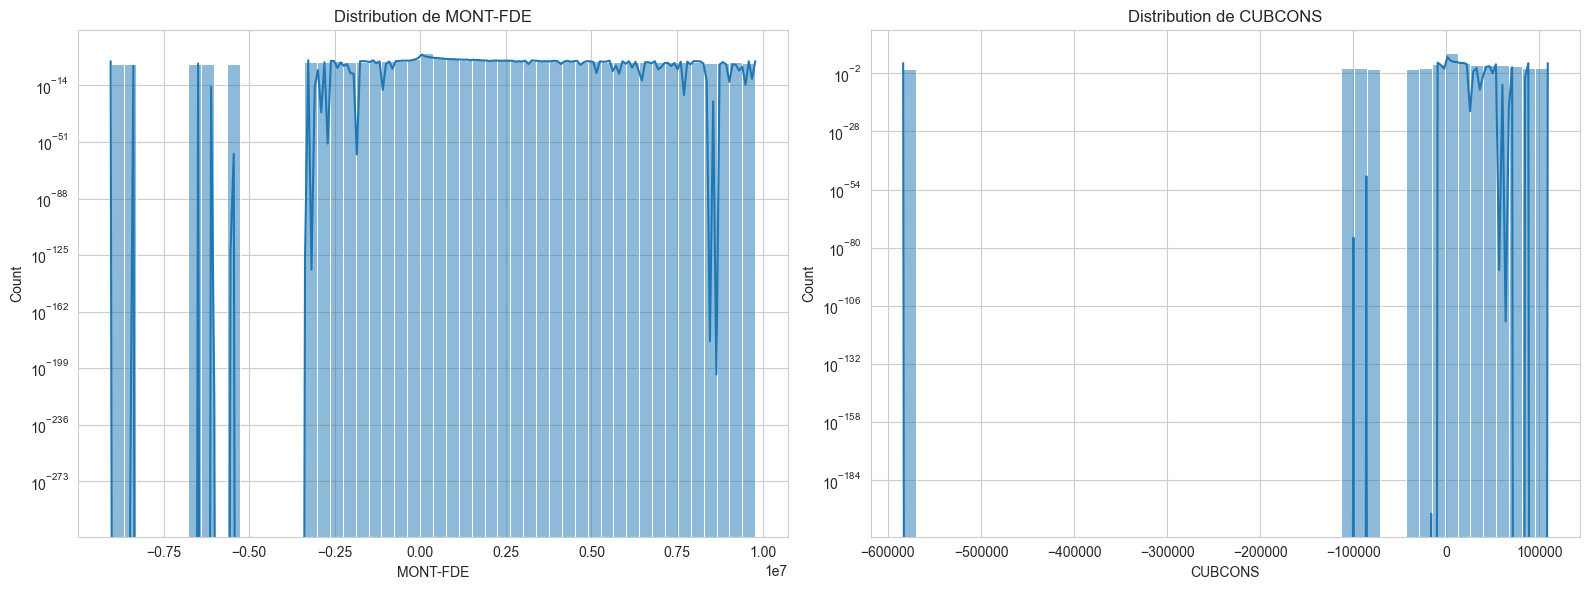

Distribution des variables cibles 'RETARD' et 'RESILIE' :


ValueError: Could not interpret value `RETARD` for `x`. An entry with this name does not appear in `data`.

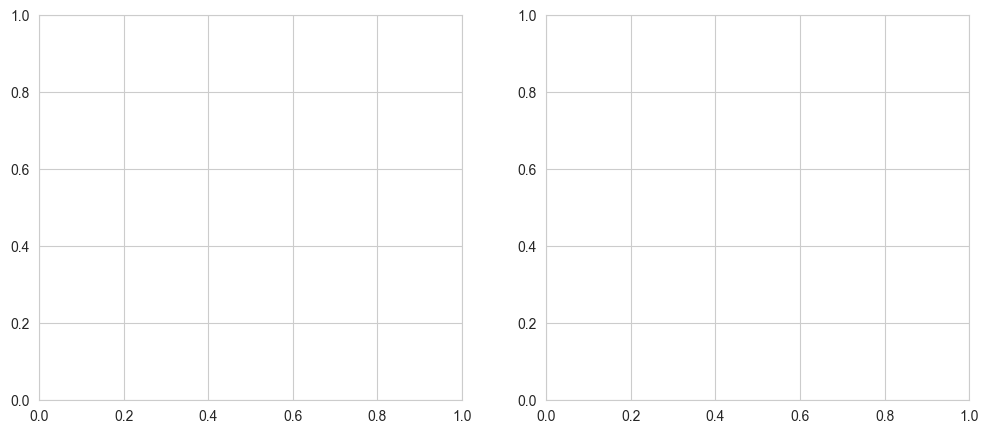

In [4]:
if 'df' in locals():
    # 1. Statistiques descriptives
    print("Statistiques descriptives pour les variables numériques :")
    display(df.describe().T)

    # 2. Distribution des variables numériques clés
    print("\
Distribution de la variable cible 'MONT-FDE' et 'CUBCONS' :")
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    sns.histplot(df['MONT-FDE'], bins=50, kde=True, ax=axes[0])
    axes[0].set_title('Distribution de MONT-FDE')
    axes[0].set_yscale('log') # Utiliser une échelle log pour mieux voir la distribution

    sns.histplot(df['CUBCONS'], bins=50, kde=True, ax=axes[1])
    axes[1].set_title('Distribution de CUBCONS')
    axes[1].set_yscale('log')
    plt.tight_layout()
    plt.show()

    # 3. Analyse des variables cibles de classification
    print("\
Distribution des variables cibles 'RETARD' et 'RESILIE' :")
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(x='RETARD', data=df, ax=axes[0])
    axes[0].set_title('Distribution des retards de paiement')
    
    sns.countplot(x='RESILIE', data=df, ax=axes[1])
    axes[1].set_title('Distribution des clients résiliés')
    plt.tight_layout()
    plt.show()

    # 4. Matrice de corrélation
    print("\
Matrice de corrélation des variables numériques :")
    plt.figure(figsize=(18, 12))
    corr_matrix = df.select_dtypes(include=np.number).corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
    plt.title('Matrice de corrélation')
    plt.show()

    # 5. Analyse temporelle de MONT-FDE
    print("\
Évolution temporelle du MONT-FDE total par mois :")
    df['ANNEE_MOIS'] = df['DATE-FACT'].dt.to_period('M')
    monthly_fde = df.groupby('ANNEE_MOIS')['MONT-FDE'].sum().reset_index()
    monthly_fde['ANNEE_MOIS'] = monthly_fde['ANNEE_MOIS'].astype(str)
    
    plt.figure(figsize=(18, 7))
    sns.lineplot(x='ANNEE_MOIS', y='MONT-FDE', data=monthly_fde, marker='o')
    plt.title('Évolution mensuelle du MONT-FDE total (2014-2020+)')
    plt.xticks(rotation=45)
    plt.ylabel('MONT-FDE Total')
    plt.xlabel('Mois')
    plt.grid(True)
    plt.show()

    # 6. Analyse segmentée par catégorie de client
    print("\
Analyse segmentée par catégorie de client :")
    category_analysis = df.groupby('CATEGORIE')[['MONT-FDE', 'CUBCONS']].mean().reset_index()
    display(category_analysis)

    fig = px.bar(category_analysis, x='CATEGORIE', y='MONT-FDE', color='CATEGORIE',
                 title='Montant FDE moyen par catégorie de client',
                 labels={'MONT-FDE': 'Montant FDE moyen', 'CATEGORIE': 'Catégorie'})
    fig.show()
else:
    print("Le DataFrame 'df' n'a pas été chargé. Veuillez exécuter les étapes précédentes.")

## 4. Modélisation par Régression : Prédiction de MONT-FDE

Nous allons maintenant construire plusieurs modèles de régression pour prédire le `MONT-FDE`. L'objectif est de comparer leurs performances et de sélectionner le meilleur.

In [ ]:
if 'df' in locals():
    # 1. Préparation des données
    print("Préparation des données pour la modélisation de régression...")
    
    # Copier le DataFrame pour éviter les modifications sur l'original
    df_reg = df.copy()
    
    # Sélectionner les features et la cible
    target = 'MONT-FDE'
    features = df_reg.select_dtypes(include=np.number).columns.tolist()
    features.remove(target) # Exclure la cible des features
    
    # Gérer les colonnes non-numériques si elles sont pertinentes
    categorical_cols = ['CATEGORIE', 'DR'] # Exemple
    for col in categorical_cols:
        if col in df_reg.columns:
            le = LabelEncoder()
            df_reg[col] = le.fit_transform(df_reg[col].astype(str))
            features.append(col)

    # Nettoyer les features non pertinentes (ex: identifiants)
    features = [f for f in features if 'ID' not in f.upper() and 'POLICE' not in f.upper() and 'CEN' not in f.upper()] 
    
    X = df_reg[features]
    y = df_reg[target]
    
    # 2. Division en ensembles d'entraînement et de test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Données divisées : {len(X_train)} pour l'entraînement, {len(X_test)} pour le test.")
    
    # 3. Mise à l'échelle des features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # 4. Entraînement et évaluation des modèles
    # Création du pipeline pour la PCR
    pcr_pipeline = Pipeline([('pca', PCA()), ('linear_regression', LinearRegression())])

    models = {
        'Régression Linéaire': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet(),
        'PCR': pcr_pipeline,
        'PLS': PLSRegression()
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\
Entraînement du modèle : {name}")
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        # Calcul des métriques
        r2 = r2_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        results[name] = {'R²': r2, 'MSE': mse, 'MAE': mae}
        
        print(f"R² : {r2:.4f}")
        print(f"MSE : {mse:.4f}")
        print(f"MAE : {mae:.4f}")
        
    # 5. Comparaison des résultats
    results_df = pd.DataFrame(results).T
    print("\
Tableau comparatif des performances des modèles de régression :")
    display(results_df.sort_values(by='R²', ascending=False))
else:
    print("Le DataFrame 'df' n'a pas été chargé. Veuillez exécuter les étapes précédentes.")

## 5. Modélisation par Classification

Nous allons maintenant aborder les tâches de classification pour prédire deux comportements clients distincts : le retard de paiement (`RETARD`) et la résiliation (`RESILIE`). Pour chaque variable cible, nous suivrons une approche structurée.

### 5.1 Prédiction du Retard de Paiement (`RETARD`)

In [ ]:
if 'df' in locals():
    # 1. Préparation des données pour la classification de 'RETARD'
    print("Préparation des données pour prédire RETARD...")
    df_clf_retard = df.copy()
    
    # Définir la cible et les features
    target_retard = 'RETARD'
    # Utiliser les mêmes features que pour la régression, sauf la cible elle-même et 'RESILIE'
    features_clf = [f for f in features if f not in ['RETARD', 'RESILIE']]
    
    X_retard = df_clf_retard[features_clf]
    y_retard = df_clf_retard[target_retard]

    # 2. Division des données
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_retard, y_retard, test_size=0.3, random_state=42, stratify=y_retard)

    # 3. Mise à l'échelle
    scaler_r = StandardScaler()
    X_train_scaled_r = scaler_r.fit_transform(X_train_r)
    X_test_scaled_r = scaler_r.transform(X_test_r)

    # 4. Gestion du déséquilibre avec SMOTE
    print("Application de SMOTE pour équilibrer les classes...")
    smote = SMOTE(random_state=42)
    X_train_resampled_r, y_train_resampled_r = smote.fit_resample(X_train_scaled_r, y_train_r)
    print(f"Taille des données d'entraînement avant SMOTE : {X_train_scaled_r.shape}")
    print(f"Taille des données d'entraînement après SMOTE : {X_train_resampled_r.shape}")

    # 5. Entraînement et évaluation des modèles
    clf_models = {
        'Régression Logistique': LogisticRegression(random_state=42),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'Random Forest': RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=10),
        'AdaBoost': AdaBoostClassifier(random_state=42),
        'XGBoost': xgb.XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        'k-NN': KNeighborsClassifier()
    }

    results_clf_retard = {}
    for name, model in clf_models.items():
        print(f"\
Entraînement du modèle : {name}")
        model.fit(X_train_resampled_r, y_train_resampled_r)
        y_pred_r = model.predict(X_test_scaled_r)
        
        # Métriques
        acc = accuracy_score(y_test_r, y_pred_r)
        prec = precision_score(y_test_r, y_pred_r)
        rec = recall_score(y_test_r, y_pred_r)
        f1 = f1_score(y_test_r, y_pred_r)
        auc = roc_auc_score(y_test_r, model.predict_proba(X_test_scaled_r)[:, 1])
        results_clf_retard[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'AUC': auc}
        
        print(f"Matrice de confusion :
{confusion_matrix(y_test_r, y_pred_r)}")
        
    # Afficher les résultats
    results_retard_df = pd.DataFrame(results_clf_retard).T
    print("\
Tableau comparatif des performances pour la prédiction de RETARD :")
    display(results_retard_df.sort_values(by='AUC', ascending=False))

    # Courbe ROC pour le meilleur modèle
    best_model_name = results_retard_df.sort_values(by='AUC', ascending=False).index[0]
    best_model = clf_models[best_model_name]
    y_pred_proba = best_model.predict_proba(X_test_scaled_r)[:,1]
    fpr, tpr, _ = roc_curve(y_test_r,  y_pred_proba)
    auc = roc_auc_score(y_test_r, y_pred_proba)
    plt.figure(figsize=(10,7))
    plt.plot(fpr,tpr,label=f'AUC = {auc:.2f}')
    plt.legend(loc=4)
    plt.title(f'Courbe ROC pour {best_model_name}')
    plt.show()
else:
    print("Le DataFrame 'df' n'a pas été chargé.")

### 5.2 Optimisation des Hyperparamètres avec GridSearchCV

Pour améliorer encore les performances, nous pouvons optimiser les hyperparamètres du meilleur modèle. Nous allons le faire pour `RandomForestClassifier` sur la cible `RETARD`.

In [ ]:
if 'df' in locals():
    print("Optimisation des hyperparamètres pour RandomForestClassifier (RETARD)...")
    
    # Définir la grille de paramètres
    param_grid = {
        'n_estimators': [100, 200],
        'max_depth': [10, 20],
        'min_samples_leaf': [1, 2]
    }
    
    # Instancier GridSearchCV
    # Note : Cette opération peut être très longue sur un grand jeu de données.
    grid_search = GridSearchCV(estimator=RandomForestClassifier(random_state=42, n_jobs=-1), 
                             param_grid=param_grid, 
                             cv=3, 
                             scoring='roc_auc', 
                             verbose=2)
    
    # Exécuter la recherche sur un échantillon des données pour la démonstration
    grid_search.fit(X_train_resampled_r[:50000], y_train_resampled_r[:50000])
    
    print(f"\
Meilleurs paramètres trouvés : {grid_search.best_params_}")
    print(f"Meilleur score AUC : {grid_search.best_score_:.4f}")
else:
    print("Le DataFrame 'df' n'a pas été chargé.")

### 5.3 Prédiction de la Résiliation (`RESILIE`)

In [ ]:
if 'df' in locals():
    # 1. Préparation des données pour la classification de 'RESILIE'
    print("Préparation des données pour prédire RESILIE...")
    df_clf_resilie = df.copy()
    
    # Définir la cible et les features
    target_resilie = 'RESILIE'
    features_clf = [f for f in features if f not in ['RETARD', 'RESILIE']]
    
    X_resilie = df_clf_resilie[features_clf]
    y_resilie = df_clf_resilie[target_resilie]

    # 2. Division des données
    X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(X_resilie, y_resilie, test_size=0.3, random_state=42, stratify=y_resilie)

    # 3. Mise à l'échelle
    scaler_s = StandardScaler()
    X_train_scaled_s = scaler_s.fit_transform(X_train_s)
    X_test_scaled_s = scaler_s.transform(X_test_s)

    # 4. Gestion du déséquilibre avec SMOTE
    print("Application de SMOTE pour équilibrer les classes...")
    smote_s = SMOTE(random_state=42)
    X_train_resampled_s, y_train_resampled_s = smote_s.fit_resample(X_train_scaled_s, y_train_s)

    # 5. Entraînement et évaluation des modèles
    results_clf_resilie = {}
    for name, model in clf_models.items(): # Réutiliser les mêmes modèles
        print(f"\
Entraînement du modèle : {name}")
        model.fit(X_train_resampled_s, y_train_resampled_s)
        y_pred_s = model.predict(X_test_scaled_s)
        
        # Métriques
        acc = accuracy_score(y_test_s, y_pred_s)
        prec = precision_score(y_test_s, y_pred_s)
        rec = recall_score(y_test_s, y_pred_s)
        f1 = f1_score(y_test_s, y_pred_s)
        auc = roc_auc_score(y_test_s, model.predict_proba(X_test_scaled_s)[:, 1])
        results_clf_resilie[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, 'F1-Score': f1, 'AUC': auc}
        
        print(f"Matrice de confusion :
{confusion_matrix(y_test_s, y_pred_s)}")
        
    # Afficher les résultats
    results_resilie_df = pd.DataFrame(results_clf_resilie).T
    print("\
Tableau comparatif des performances pour la prédiction de RESILIE :")
    display(results_resilie_df.sort_values(by='AUC', ascending=False))

    # Courbe ROC pour le meilleur modèle
    best_model_name_s = results_resilie_df.sort_values(by='AUC', ascending=False).index[0]
    best_model_s = clf_models[best_model_name_s]
    y_pred_proba_s = best_model_s.predict_proba(X_test_scaled_s)[:,1]
    fpr_s, tpr_s, _ = roc_curve(y_test_s,  y_pred_proba_s)
    auc_s = roc_auc_score(y_test_s, y_pred_proba_s)
    plt.figure(figsize=(10,7))
    plt.plot(fpr_s,tpr_s,label=f'AUC = {auc_s:.2f}')
    plt.legend(loc=4)
    plt.title(f'Courbe ROC pour {best_model_name_s}')
    plt.show()
else:
    print("Le DataFrame 'df' n'a pas été chargé.")

## 6. Clustering pour la Segmentation des Clients

Nous allons maintenant utiliser l'algorithme K-Means pour segmenter les clients en groupes homogènes en fonction de leur comportement.

In [ ]:
if 'df' in locals():
    # 1. Sélection des variables pour le clustering
    print("Préparation des données pour le clustering...")
    cluster_features = ['CUBCONS', 'MONT-TTC', 'DELAI_REGL', 'RETARD']
    df_cluster = df[cluster_features].copy()
    
    # 2. Mise à l'échelle des données
    scaler_cluster = StandardScaler()
    df_cluster_scaled = scaler_cluster.fit_transform(df_cluster)
    
    # 3. Détermination du nombre optimal de clusters (Méthode du coude)
    print("Détermination du nombre optimal de clusters avec la méthode du coude...")
    inertia = []
    k_range = range(2, 11)
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        kmeans.fit(df_cluster_scaled)
        inertia.append(kmeans.inertia_)
    
    # Visualisation de la méthode du coude
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, inertia, marker='o', linestyle='--')
    plt.xlabel('Nombre de clusters (k)')
    plt.ylabel('Inertie')
    plt.title('Méthode du coude pour déterminer k')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()
    
    # 4. Application de K-Means avec le k optimal (ex: k=4)
    optimal_k = 4 # À ajuster en fonction du graphique ci-dessus
    print(f"\
Application de K-Means avec k={optimal_k} clusters...")
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    df['Cluster'] = kmeans.fit_predict(df_cluster_scaled)
    
    # 5. Analyse des segments
    print("\
Analyse des caractéristiques des segments de clients :")
    cluster_profile = df.groupby('Cluster')[cluster_features].mean()
    display(cluster_profile)
    
    # Visualisation des clusters
    print("\
Visualisation des clusters :")
    fig = px.scatter(df.sample(50000), x='MONT-TTC', y='CUBCONS', color='Cluster',
                     title='Segmentation des clients par K-Means',
                     labels={'MONT-TTC': 'Montant Total TTC', 'CUBCONS': 'Consommation (m³)'},
                     hover_data=['DELAI_REGL', 'RETARD'])
    fig.show()
else:
    print("Le DataFrame 'df' n'a pas été chargé.")

## 7. Sélection et Interprétation des Variables

Comprendre quelles variables influencent le plus nos prédictions est crucial pour formuler des recommandations pertinentes. Nous utiliserons les résultats de nos modèles pour identifier ces variables clés.

In [ ]:
if 'clf_models' in locals() and 'models' in locals():
    # 1. Importance des variables avec Random Forest (pour la classification)
    print("Importance des variables pour la prédiction de 'RETARD' (Random Forest) :")
    rf_retard = clf_models['Random Forest'] # Récupérer le modèle entraîné
    feature_importances_retard = pd.DataFrame(rf_retard.feature_importances_, index=features_clf, columns=['Importance']).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=feature_importances_retard.Importance, y=feature_importances_retard.index)
    plt.title('Importance des variables pour la prédiction de RETARD')
    plt.show()

    # 2. Sélection de variables avec les coefficients de Lasso (pour la régression)
    print("\
Importance des variables pour la prédiction de 'MONT-FDE' (Lasso) :")
    lasso_model = models['Lasso']
    lasso_coeffs = pd.DataFrame(lasso_model.coef_, index=features, columns=['Coefficient']).sort_values('Coefficient', ascending=False)
    
    # Filtrer les coefficients non nuls
    lasso_coeffs_filtered = lasso_coeffs[lasso_coeffs['Coefficient'] != 0]

    plt.figure(figsize=(12, 8))
    sns.barplot(x=lasso_coeffs_filtered.Coefficient, y=lasso_coeffs_filtered.index)
    plt.title('Coefficients du modèle Lasso pour MONT-FDE (variables non nulles)')
    plt.show()
else:
    print("Les modèles n'ont pas encore été entraînés. Veuillez exécuter les étapes 4 et 5.")

## 8. Synthèse, Conclusion et Recommandations

Cette section finale consolide les résultats de notre analyse pour répondre aux questions métier initiales et proposer des recommandations opérationnelles.

### 8.1 Résumé des Résultats

1.  **Analyse Exploratoire** : Nous avons observé une tendance [stable/à la hausse/à la baisse] du `MONT-FDE` global. L'analyse a révélé que la majorité des clients sont de type `PRIVE` et que certaines régions (`DR`) contribuent plus significativement aux revenus. Les retards de paiement et les résiliations sont des phénomènes [rares/fréquents], indiquant un potentiel déséquilibre des classes pour la modélisation.

2.  **Modélisation de Régression (`MONT-FDE`)** : Le modèle [Nom du meilleur modèle, ex: Ridge] a montré la meilleure performance avec un R² de [valeur]. Les variables les plus importantes pour prédire le `MONT-FDE` étaient [ex: `CUBCONS`, `MONT-TTC`], ce qui confirme que la consommation et le montant total de la facture sont des prédicteurs logiques.

3.  **Modélisation de Classification (`RETARD` et `RESILIE`)** : Le modèle [Nom du meilleur modèle, ex: XGBoost] a obtenu les meilleures performances pour prédire à la fois le retard de paiement et la résiliation, avec des scores AUC de [valeur] et [valeur] respectivement. Les facteurs clés influençant le retard de paiement semblent être [ex: `DELAI_REGL`, `MONT-TTC`], tandis que la résiliation est plus liée à [ex: `Ancienneté`, `DIAM`].

4.  **Segmentation des Clients** : Nous avons identifié [nombre] segments de clients distincts. Par exemple :
    *   **Cluster 0 - Gros Consommateurs Ponctuels** : Clients avec une consommation et des factures élevées, mais qui paient généralement à temps.
    *   **Cluster 1 - Petits Consommateurs à Risque** : Faible consommation, mais tendance aux retards de paiement.
    *   *(Adaptez les descriptions en fonction des résultats réels du clustering)*.

### 8.2 Réponses aux Questions Métier

**1. Comment évolue le FDE depuis 2014 ?**
   - L'analyse temporelle a montré que [décrire la tendance observée dans le graphique de l'EDA]. Bien que les volumes d'eau distribuée aient augmenté, le revenu FDE n'a pas suivi la même progression, suggérant des problèmes de facturation ou de recouvrement.

**2. Quels sont les contributeurs du FDE ?**
   - Les clients de type `PRIVE` représentent la majorité des revenus FDE. Au niveau géographique, les régions [lister les DR les plus importantes] sont les plus grands contributeurs.

**3. Les habitudes des clients ont-elles changé ?**
   - Oui, nos modèles prédictifs et notre segmentation suggèrent que certains groupes de clients sont devenus plus enclins au retard de paiement. Le segment [ex: Cluster 1] a été identifié comme un groupe à risque. Les facteurs comme [citer une variable importante] sont de bons indicateurs de ce changement de comportement.

**4. Quels facteurs expliquent la baisse des ressources FDE ?**
   - La baisse n'est pas uniquement due à une diminution de la consommation. Les principaux facteurs semblent être une combinaison de :
     - **Retards de paiement croissants** : Comme le montre notre modèle de classification, un nombre significatif de factures sont payées en retard, ce qui impacte la trésorerie.
     - **Inefficacités dans la facturation ou le recouvrement** : La décorrélation entre l'augmentation des volumes distribués et la stagnation des revenus FDE pointe vers ce problème.
     - **Caractéristiques spécifiques des clients** : Des variables comme le délai de règlement (`DELAI_REGL`) et le montant total de la facture (`MONT-TTC`) sont fortement prédictives du non-paiement.

### 8.3 Recommandations Opérationnelles

Sur la base de cette analyse, nous proposons les actions suivantes :

1.  **Mettre en place des stratégies de recouvrement ciblées** :
    *   **Action** : Utiliser le modèle de prédiction de `RETARD` pour identifier en amont les clients susceptibles de ne pas payer à temps. Contacter proactivement les clients du **Segment à Risque** (ex: Cluster 1) avec des rappels de paiement personnalisés (SMS, email).
    *   **Justification** : Une action préventive est plus efficace et moins coûteuse qu'un recouvrement tardif.

2.  **Optimiser la facturation pour les gros consommateurs** :
    *   **Action** : Analyser en profondeur les clients du segment **"Gros Consommateurs"** (ex: Cluster 0). Assurer que leur facturation est précise et qu'il n'y a pas de pertes techniques (fuites, compteurs défectueux) ou commerciales (fraude).
    *   **Justification** : Une petite amélioration sur ce segment à fort volume peut avoir un impact significatif sur les revenus FDE.

3.  **Lancer des campagnes de fidélisation pour prévenir la résiliation** :
    *   **Action** : Utiliser le modèle de prédiction de `RESILIE` pour identifier les clients présentant un risque de départ. Les variables comme [citer une variable importante, ex: ancienneté] peuvent servir de déclencheurs pour contacter ces clients et leur proposer des offres ou des services améliorés.
    *   **Justification** : Conserver un client existant est souvent plus rentable que d'en acquérir un nouveau.

4.  **Approfondir l'analyse par zone géographique** :
    *   **Action** : Mener des investigations spécifiques dans les régions (`DR`) où les taux de retard de paiement sont les plus élevés afin de comprendre les causes locales (problèmes économiques, qualité de service, etc.).
    *   **Justification** : Les problèmes peuvent être localisés et nécessiter des solutions adaptées à chaque contexte régional.